# Symmetry breaking in sequence training
This notebook is to study sequences that only run to one side. How the different time constans make the sequence only run in one direction while recalling. We start as usual by loadin the libraries

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from network import BCPNN, NetworkManager
from data_transformer import build_ortogonal_patterns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

#### Git loading
Here we have the git machinery to re-run this again with the last working version

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'def84352a570b32e00ceb1f77bfe1656616b75dd'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

## Network training

We build the patterns and the network first

In [3]:
hypercolumns = 2
minicolumns = 10
n_patterns = 5  # Number of patterns

patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

# Build the network
tau_z_pre = 0.500
tau_z_post = 0.125

nn = BCPNN(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre)

Then we build the network manager

In [4]:
dt = 0.001
T_training = 1.0
time_training = np.arange(0, T_training, dt)
T_ground = 0.5
time_ground = np.arange(0, T_ground, dt)
values_to_save = ['o', 'a', 'z_pre', 'z_post', 'p_pre', 'p_post', 'p_co', 'z_co', 'w']

manager = NetworkManager(nn=nn, values_to_save=values_to_save)

We do the training

In [5]:
repetitions = 3
resting_state =  False
for i in range(repetitions):
    print('repetitions', i)
    for pattern in patterns:
        nn.k = 1.0
        manager.run_network(time=time_training, I=pattern)
        nn.k = 0.0
        if resting_state:
            manager.run_network(time=time_ground)

history = manager.history

if resting_state:
    T_total = n_patterns * repetitions * (T_training + T_ground)
else:
    T_total = n_patterns * repetitions * T_training
    
total_time = np.arange(0, T_total, dt)

repetitions 0
repetitions 1
repetitions 2


We extract the relevant variables

In [6]:
z_pre_hypercolum = history['z_pre'][..., :minicolumns]
z_post_hypercolum = history['z_post'][..., :minicolumns]
o_hypercolum = history['o'][..., :minicolumns]
p_pre_hypercolum = history['p_pre'][..., :minicolumns]
p_post_hypercolum = history['p_post'][..., :minicolumns]

p_co = history['p_co']
z_co = history['z_co']
w = history['w']

p_co12 = p_co[:, 1, 2]
p_co32 = p_co[:, 3, 2]

z_co12 = z_co[:, 1, 2]
z_co32 = z_co[:, 3, 2]

w12 = w[:, 1, 2]
w32 = w[:, 3, 2]

aux12 = p_co12 / (p_pre_hypercolum[:, 1] * p_post_hypercolum[:, 2])
aux32 = p_co32 / (p_pre_hypercolum[:, 3] * p_post_hypercolum[:, 2])

#### Plotting

In [7]:
import seaborn as sns
sns.set_context('notebook', font_scale=2.0)

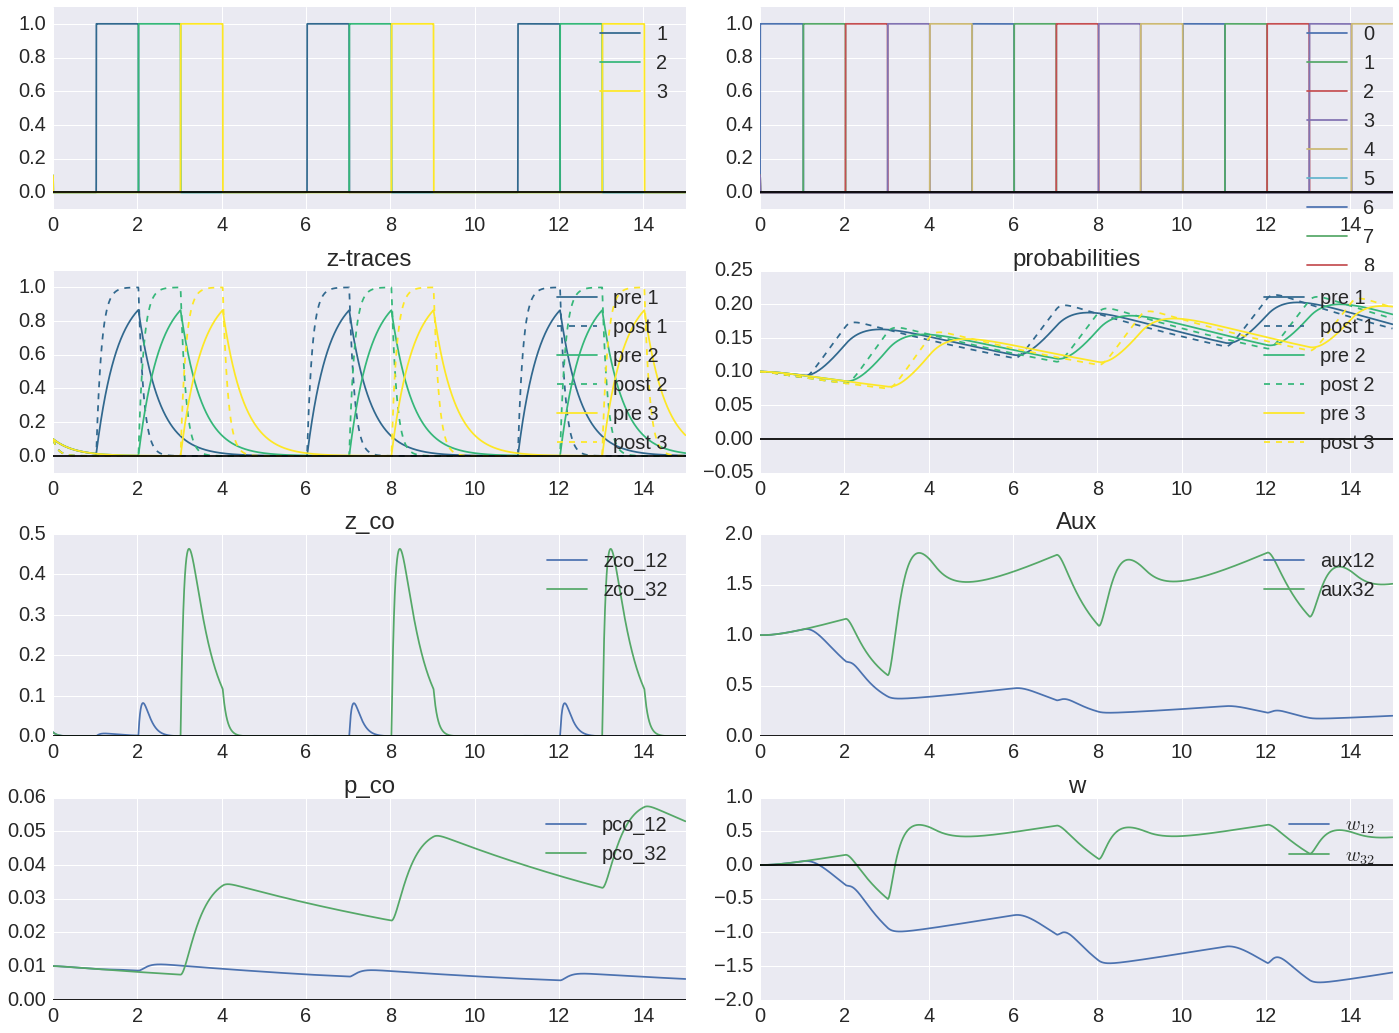

In [8]:
cmap = matplotlib.cm.get_cmap('viridis')
traces_to_plot = [1, 2, 3]
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(traces_to_plot))

# Plot the traces
fig = plt.figure(figsize=(20, 15))
ax11 = fig.add_subplot(421)
ax12 = fig.add_subplot(422)
ax21 = fig.add_subplot(423)
ax22 = fig.add_subplot(424)
ax31 = fig.add_subplot(425)
ax32 = fig.add_subplot(426)
ax41 = fig.add_subplot(427)
ax42 = fig.add_subplot(428)

fig.tight_layout()

for index in range(minicolumns):
    # Plot ALL the activities
    ax12.plot(total_time, o_hypercolum[:, index], label=str(index))


for index in traces_to_plot:
    # Plot activities
    ax11.plot(total_time, o_hypercolum[:, index], color=cmap(norm(index)), label=str(index))
    # Plot the z post and pre traces in the same graph
    ax21.plot(total_time, z_pre_hypercolum[:, index], color=cmap(norm(index)), label='pre ' + str(index))
    ax21.plot(total_time, z_post_hypercolum[:, index], color=cmap(norm(index)), linestyle='--', label='post ' + str(index))

    # Plot the pre and post probabilties in the same graph
    ax22.plot(total_time, p_pre_hypercolum[:, index], color=cmap(norm(index)), label='pre ' + str(index))
    ax22.plot(total_time, p_post_hypercolum[:, index], color=cmap(norm(index)), linestyle='--', label='post ' + str(index))

# Plot z_co and p_co in the same graph
ax31.plot(total_time, z_co12, label='zco_12')
ax31.plot(total_time, z_co32, label='zco_32')

# Plot the aux quantity
ax32.plot(total_time, aux12, label='aux12')
ax32.plot(total_time, aux32, label='aux32')

# Plot the coactivations probabilities
ax41.plot(total_time, p_co12, '-', label='pco_12')
ax41.plot(total_time, p_co32, '-',label='pco_32')

# Plot the weights
ax42.plot(total_time, w12, label=r'$w_{12}$')
ax42.plot(total_time, w32, label=r'$w_{32}$')

axes = fig.get_axes()
for ax in axes:
    ax.set_xlim([0, T_total])
    ax.legend()
    ax.axhline(0, color='black')


ax11.set_ylim([-0.1, 1.1])
ax12.set_ylim([-0.1, 1.1])
ax21.set_ylim([-0.1, 1.1])

ax21.set_title('z-traces')
ax22.set_title('probabilities')
ax31.set_title('z_co')
ax32.set_title('Aux')
ax41.set_title('p_co')
ax42.set_title('w')

plt.show()

#### Connectivity matrix

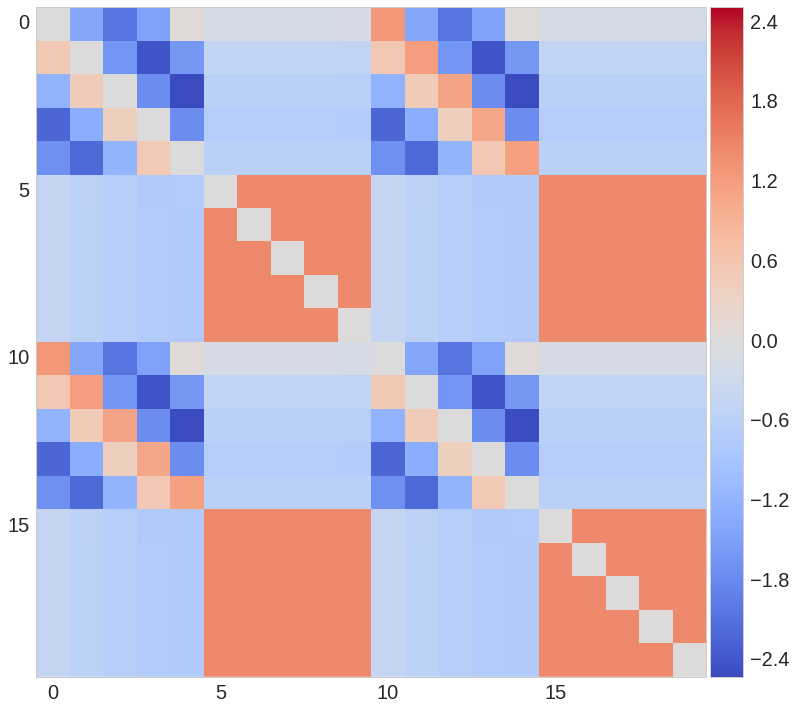

In [9]:
sns.set_style("whitegrid", {'axes.grid' : False})
w = nn.w
aux_max = np.max(np.abs(w))

cmap = 'coolwarm'
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(111)
im1 = ax1.imshow(w, cmap=cmap, interpolation='None', vmin=-aux_max, vmax=aux_max)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, ax=ax1, cax=cax1)

## Network recalling

In [10]:
nn.k = 0
manager.empty_history()
nn.reset_values(keep_connectivity=True)
T_recalling = 10.0
time_recalling = np.arange(0, T_recalling + dt, dt)

manager.run_network(time=time_recalling)

history = manager.history

#### Plot recalling

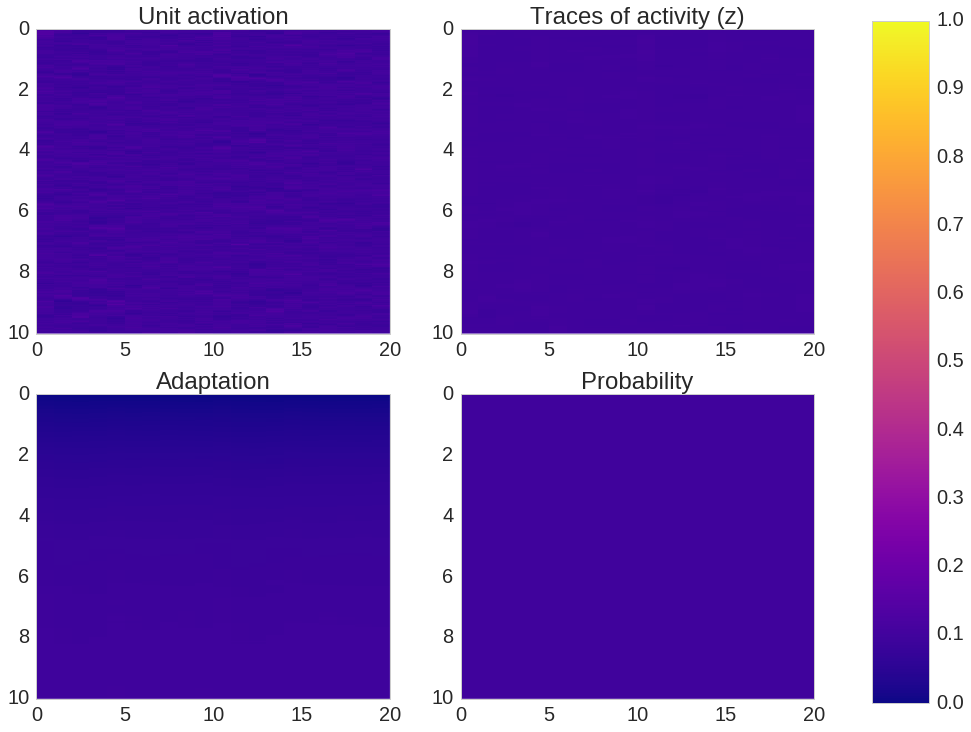

In [11]:
cmap = 'plasma'
extent = [0, minicolumns * hypercolumns, T_recalling, 0]

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(history['o'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax1.set_title('Unit activation')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(history['z_pre'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax2.set_title('Traces of activity (z)')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(history['a'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax3.set_title('Adaptation')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(history['p_pre'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax4.set_title('Probability')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.79])
fig.colorbar(im1, cax=cbar_ax)

#### Git reset

In [12]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])